In [2]:
#https://pypi.org/project/jetson-emulator/#description 
!pip install jetson-emulator

In [7]:
import jetson_emulator.inference as inference
import jetson_emulator.utils as utils
import numpy as np

In [9]:
#sample imagenet
# load the recognition network
net = inference.imageNet("googlenet")
for x in range(1,6):
    # emulator API to generate sample images for imageNet
    filename = net.emulatorGetImageFile()      
    img = utils.loadImage(filename) 
    class_idx, confidence = net.Classify(img)            
    class_desc = net.GetClassDesc(class_idx)            
    print("image "+str(x)+" is recognized as '{:s}' (class #{:d}) with {:f}% confidence".
    format(class_desc, class_idx, confidence*100))

image 1 is recognized as 'unicycle, monocycle' (class #880) with 11.233178% confidence
image 2 is recognized as 'mushroom' (class #947) with 38.123597% confidence
image 3 is recognized as 'mobile home, manufactured home' (class #660) with 69.408385% confidence
image 4 is recognized as 'wallet, billfold, notecase, pocketbook' (class #893) with 90.122862% confidence
image 5 is recognized as 'CD player' (class #485) with 97.776008% confidence


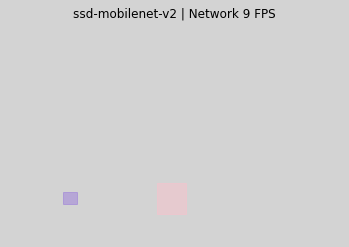

detected 2 objects in image

class_desc: person
<jetson.inference.Detection object>
   -- ClassID: 2
   -- Confidence: 0.992871
   -- Left: 638.0
   -- Top: 1687.0
   -- Right: 804.0
   -- Bottom: 1807.0
   -- Width: 166.0
   -- Height: 120.0
   -- Area: 19920.0
   -- Center: (721.0, 1747.0)

class_desc: bicycle
<jetson.inference.Detection object>
   -- ClassID: 3
   -- Confidence: 0.528252
   -- Left: 1720.0
   -- Top: 1595.0
   -- Right: 2050.0
   -- Bottom: 1899.0
   -- Width: 330.0
   -- Height: 304.0
   -- Area: 100320.0
   -- Center: (1885.0, 1747.0)



In [10]:
#sample object detection
network = "ssd-mobilenet-v2"
net = inference.detectNet(network, threshold=0.5)
input_URI = "rtsp://jetson_emulator:554/detectNet/road_cam/4k" 
input  = utils.videoSource(input_URI, argv="")
output = utils.videoOutput("display://1", argv="")
img = input.Capture()
detections = net.Detect(img, "box")
output.SetStatus("{:s} | Network {:.0f} FPS".format(network, net.GetNetworkFPS()))
output.Render(img)
print("detected {:d} objects in image\n".format(len(detections)) )
for detection in detections:
    print("class_desc:", net.GetClassDesc(detection.ClassID))  
    print(detection)

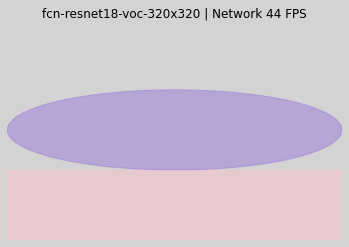

-----------------------------------------
 ID  class name         count   %
-----------------------------------------
  0  background         17600   0.171875
  1  aeroplane              0   0.000000
  2  bicycle                0   0.000000
  3  bird                   0   0.000000
  4  boat                   0   0.000000
  5  bottle                 0   0.000000
  6  bus                    0   0.000000
  7  car                    0   0.000000
  8  cat                    0   0.000000
  9  chair                  0   0.000000
 10  cow                    0   0.000000
 11  diningtable            0   0.000000
 12  dog                    0   0.000000
 13  horse                  0   0.000000
 14  motorbike              0   0.000000
 15  person             21440   0.209375
 16  pottedplant            0   0.000000
 17  sheep                  0   0.000000
 18  sofa               63360   0.618750


In [8]:
network = "fcn-resnet18-voc-320x320"
net = inference.segNet(network, None)
input_URI = "rtsp://jetson_emulator:554/segNet/sofa_cam/4k"
input  = utils.videoSource(input_URI, None)
output = utils.videoOutput("display://1", None)
img = input.Capture()
net.Process(img, ignore_class="void")

# get image mask for video output
img_mask = utils.cudaAllocMapped(width=img.shape[1], height=img.shape[0], format=img.format) 
net.Mask(img_mask, img_mask.shape[1], img_mask.shape[0], filter_mode="linear")
output.SetStatus("{:s} | Network {:.0f} FPS".format(network, net.GetNetworkFPS()))
output.Render(img_mask)

# get class mask to calculate histogram
grid_width, grid_height = net.GetGridSize()
class_mask = utils.cudaAllocMapped(width=grid_width, height=grid_height, format="gray8")
net.Mask(class_mask, grid_width, grid_height, filter_mode="linear")
class_mask_np = utils.cudaToNumpy(class_mask)

# compute the number of times each class occurs in the mask
max_class = np.amax(class_mask_np)
class_histogram, _ = np.histogram(class_mask_np, bins=max_class+1, density=False)
print('-----------------------------------------')
print(' ID  class name         count   %')
print('-----------------------------------------')
for n in range(max_class+1):
    percentage = float(class_histogram[n]) / float(grid_width * grid_height)
    print(' {:>2d}  {:<18s} {:>5d}   {:f}'.format(n, net.GetClassDesc(n), class_histogram[n], percentage)) 